# Disease Norm

In this example, we'll be writing an application to extract *mentions of* diseases from Pubmed abstracts, using annotations from the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial, which has 5 parts, walks through the process of constructing a model to classify _candidate_ disease mentions as either true (i.e., that it is truly a mention of a disease) or false.

## Plan of action:

Two types of LFs:
1. TYPE I: Leveraging sources of WS (e.g. DS)
2. TYPE II: Expressing heuristics (e.g. magnifying user effort)

TYPE I:
- Need to break up MESH into subtrees and have each one be an LF!
- Need to provide negative signal

TYPE II:
- Conduct "simulated expert" experiment: go through, label examples, write LFs- what is the effective multiplier over binary labeling??
    * E.g. "renal failure"; add {"renal" -> "kidney"} to synonym map

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass

Disease = candidate_subclass('Disease', ['disease'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates').one()
print len(train)
dev = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates').one()
print len(dev)

28087
27896


In [3]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

L_gold_train = label_manager.load(session, train, "CDR Training Label Set")
print L_gold_train.shape
L_gold_dev = label_manager.load(session, dev, "CDR Development Label Set")
print L_gold_dev.shape

(28087, 1)
(27896, 1)


# Writing some multinomial LFs

## TYPE I LF: Subsets of MESH dictionary

In [4]:
from cPickle import load
from utils import load_mesh_raw

MESH_to_CID = load(open('MESH_to_CID.pkl', 'rb'))
mesh_entries = load_mesh_raw('data/desc2017.xml')

Loaded 28472 entries


## MESH exact match

In [34]:
mesh_tree = defaultdict(list)
for entry in mesh_entries:
    mid, tree_nums, terms = entry
    for tn in tree_nums:
        path = [tn[0]] + tn[1:].split(".")
        for term in terms:
            mesh_tree[term].append((mid, path))

### Augmenting MESH with UMLS

In [35]:
mid_to_paths = defaultdict(list)
for entry in mesh_entries:
    mid, tree_nums, terms = entry
    for tn in tree_nums:
        path = [tn[0]] + tn[1:].split(".")
        mid_to_paths[mid].append(path)

In [36]:
len(mesh_tree)

231579

In [37]:
with open('cui2mesh.tsv', 'rb') as f:
    for line in f:
        term, cui, mid = line.rstrip('\n').split('\t')
        for path in mid_to_paths[mid]:
            x = (mid, path)
            t = term.lower()
            if x not in mesh_tree[t]:
                mesh_tree[t].append(x)

In [38]:
len(mesh_tree)

260158

In [252]:
POS_DEPTH = 2
NEG_DEPTH = 2

def LFG_MESH_exact(c):
    p = c.disease.get_span().lower()
    if p in mesh_tree:
        seen = set()
        for mid, path in mesh_tree[p]:
            value = MESH_to_CID[mid] if path[0] in ['C', 'F'] else -1
            key   = "_".join(path[:POS_DEPTH]) if value > 0 else "_".join(path[:NEG_DEPTH])
            if key not in seen:
                seen.add(key)
                yield key, value

In [253]:
%time L_train = label_manager.create(session, train, 'LF Training Labels -- E2/2 + C2/2 + NEGS', f=LFG_MESH_exact)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 1min 36s, sys: 16.4 s, total: 1min 53s
Wall time: 1min 41s


<28087x105 sparse matrix of type '<type 'numpy.float64'>'
	with 13440 stored elements in Compressed Sparse Row format>

In [ ]:
# LOAD if already computed
L_train = label_manager.load(session, train, 'LF Training Labels -- MESH Exact + Cosine')
L_train

In [ ]:
L_train.lf_stats(labels=L_gold_train)

### Drop JJs

In [168]:
def drop_jjs(c):
    toks  = []
    words = c.disease.get_attrib_tokens()
    for i, tag in enumerate(c.disease.get_attrib_tokens('pos_tags')):
        if re.match(r'JJ.*', tag) is None:
            toks.append(words[i])
    return " ".join(toks).lower()

In [254]:
POS_DEPTH = 2
NEG_DEPTH = 2

def LFG_MESH_exact_drop_JJs(c):
    p = drop_jjs(c)
    if p in mesh_tree:
        seen = set()
        for mid, path in mesh_tree[p]:
            value = MESH_to_CID[mid] if path[0] in ['C', 'F'] else -1
            key   = "_".join(path[:POS_DEPTH]) if value > 0 else "_".join(path[:NEG_DEPTH])
            if key not in seen:
                seen.add(key)
                yield key, value

In [255]:
%time L_train = label_manager.update(session, train, 'LF Training Labels -- E2/2 + C2/2 + NEGS', True, LFG_MESH_exact_drop_JJs)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 1min 39s, sys: 16.4 s, total: 1min 56s
Wall time: 1min 44s


<28087x106 sparse matrix of type '<type 'numpy.float64'>'
	with 15368 stored elements in Compressed Sparse Row format>

## MESH TF-IDF cosine match

In [40]:
%%time
from entity_norm import CanonDictVectorizer

# Compile all terms into one dictionary
all_diseases = {}
for term, entries in mesh_tree.iteritems():
    if len(entries) > 0:
        mid, path = entries[0]  # Hack: should take the most frequent?
        all_diseases[term] = mid

# Create a vectorizer based around this 
cd_vectorizer = CanonDictVectorizer(all_diseases, other_phrases=[])

# Vectorize the dictionary
disease_phrases = []
disease_cids    = []
for term, mid in all_diseases.iteritems():
    disease_phrases.append(term)
    disease_cids.append(mid)   
D  = cd_vectorizer.vectorize_phrases(disease_phrases)
Dt = D.T
Dt

|V| = 49753
CPU times: user 1min 36s, sys: 525 ms, total: 1min 36s
Wall time: 1min 36s


In [41]:
Dt

<49754x260158 sparse matrix of type '<type 'numpy.float64'>'
	with 664037 stored elements in Compressed Sparse Column format>

In [42]:
mesh_tree_index = []
for dp in disease_phrases:
    mesh_tree_index.append(mesh_tree[dp])

In [256]:
POS_DEPTH = 2
NEG_DEPTH = 2

#THRESHs = [0.5, 0.75]
THRESHs = [0.75]

def LFG_MESH_cosine(c):
    mt = min(THRESHs)
    
    # Vectorize the phrase
    p  = c.disease.get_span().lower()
    cx = cd_vectorizer.vectorize_phrases([p])
    m  = cx * Dt
    
    # Keep track of the highest-score match so far _for each LF_
    highest_score = defaultdict(float)
    
    # Iterate over non-zero dictionary term matches > THRESH
    # Note: changing to COO and iterating over the data direcltly is ~OM faster
    m = m.tocoo()
    for i, s in enumerate(m.data):
        if s > mt:
            j = m.col[i]
            for entry in mesh_tree_index[j]:
                mid, path = entry
                value     = MESH_to_CID[mid] if path[0] in ['C', 'F'] else -1
                
                # We define each LF by a tree path code
                key = "_".join(path[:POS_DEPTH]) + "_c" if value > 0 else "_".join(path[:NEG_DEPTH]) + "_c"
                
                # Only yield this value if higher than highest current emitted
                # Note: This will just update the current value in the DB
                if s > highest_score[key]:
                    for t in THRESHs:
                        if s > t:
                            highest_score[key] = s
                            yield key + "_%s" % t, value

In [257]:
%time L_train = label_manager.update(session, train, 'LF Training Labels -- E2/2 + C2/2 + NEGS', True, LFG_MESH_cosine)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 8min 1s, sys: 22 s, total: 8min 23s
Wall time: 8min 7s


<28087x220 sparse matrix of type '<type 'numpy.float64'>'
	with 58689 stored elements in Compressed Sparse Row format>

In [ ]:
# LOAD if already computed
L_train = label_manager.load(session, train, 'LF Training Labels -- MESH Exact + Cosine')
L_train

# Putting in some negative LFs

In [90]:
import re
from lf_terms import *
from snorkel.lf_helpers import get_left_tokens, get_right_tokens
from utils import *
from Disease_Tagging_Tutorial_LFs import *
chemicals = load_chemdner_dictionary()

def LF_organs(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in organs else 0      

def LF_chemical_name(c):
    phrase = " ".join(c[0].get_attrib_tokens())
    return -1 if phrase in chemicals and not phrase.isupper() else 0

def LF_bodysym(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in bodysym else 0  

def LF_protein_chemical_abbrv(c):
    '''Gene/protein/chemical name'''
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("\d+",lemma) else 0

def LF_base_pair_seq(c): 
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("^[GACT]{2,}$",lemma) else 0

LFs_false = [LF_chemical_name,
             LF_organs,
             LF_bodysym,
             LF_protein_chemical_abbrv,
             LF_base_pair_seq,
             LF_too_vague,
             LF_neg_surfix,
             LF_non_common_disease,
             LF_non_disease_acronyms,
             LF_pos_in,
             LF_gene_chromosome_link,
             LF_right_window_incomplete,
             LF_negative_indicator
            ]

In [258]:
%time L_train = label_manager.update(session, train, 'LF Training Labels -- E2/2 + C2/2 + NEGS', True, LFs_false)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 5min 26s, sys: 17.7 s, total: 5min 43s
Wall time: 5min 31s


<28087x233 sparse matrix of type '<type 'numpy.float64'>'
	with 72612 stored elements in Compressed Sparse Row format>

In [269]:
# LOAD if already computed
L_train = label_manager.load(session, train, 'LF Training Labels -- E3/3 + C3/3')
L_train

<28087x1620 sparse matrix of type '<type 'numpy.float64'>'
	with 98467 stored elements in Compressed Sparse Row format>

# Different cut levels:

Note: G = gen model on training set, D = disc. model on test set

* Pos: 1, Neg: 1, Pos-cosine: 1, Neg-cosine: 1, Thresh-cosine: 0.75 = 56 F1 G / 63 F1 D
* TODO...
* Pos: 3, Neg: 3, Pos-cosine: 3, Neg-cosine: 3, Thresh-cosine: 0.75 = 61 F1 G / 68 F1 D
* Pos: 3, Neg: 3, Pos-cosine: 3, Neg-cosine: 3, Thresh-cosine: [0.5, 0.75] = 63 F1 G / 65 F1 D
* Pos: 4, Neg: 4, Pos-cosine: 4, Neg-cosine: 4, Thresh-cosine: 0.75 = 60 F1 G / 64 F1 D

### Adding in drop_JJs + NEG LFs:

* Pos: 2, Neg: 2, Pos-cosine: 2, Neg-cosine: 2, Thresh-cosine: 0.75 = 69 F1 G / 71 F1 D
* Pos: 3, Neg: 3, Pos-cosine: 3, Neg-cosine: 3, Thresh-cosine: 0.75 = 70 F1 G / 73 F1 D


#### Note: we're not yet dealing with acronyms!!!

In [ ]:
L_train.lf_stats(labels=L_gold_train)

# Running gen. model

In [17]:
from scipy.sparse import lil_matrix

def binarize_LF_matrix(X):
    X_b = lil_matrix(X.shape)
    for i, j in zip(*X.nonzero()):
        X_b[i,j] = np.sign(X[i,j])
    return X_b.tocsr()

In [18]:
def get_score(predicted, gold):
    tp = 0
    pp = 0
    p  = 0
    for i in range(gold.shape[0]):
        if gold[i] > 0:
            p += 1
        
        if predicted[i] == 1:
            pp += 1
            if gold[i] > 0:
                tp += 1
    
    prec   = tp / float(pp)
    recall = tp / float(p)
    f1     = (2*prec*recall) / (prec+recall)
    print "P :\t", prec
    print "R :\t", recall
    print "F1:\t", f1

In [270]:
L_train_b = binarize_LF_matrix(L_train)
L_train_b

<28087x1620 sparse matrix of type '<type 'numpy.float64'>'
	with 98467 stored elements in Compressed Sparse Row format>

In [291]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
%time gen_model.train(L_train_b, n_iter=5000, rate=1e-1, verbose=True)

Training marginals (!= 0.5):	28087
Features:			1620
Begin training for rate=0.1, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.177484
	Learning epoch = 250	Gradient mag. = 0.204523
	Learning epoch = 500	Gradient mag. = 0.210193
	Learning epoch = 750	Gradient mag. = 0.200900
	Learning epoch = 1000	Gradient mag. = 0.184622
	Learning epoch = 1250	Gradient mag. = 0.170764
	Learning epoch = 1500	Gradient mag. = 0.154063
	Learning epoch = 1750	Gradient mag. = 0.142462
	Learning epoch = 2000	Gradient mag. = 0.134760
	Learning epoch = 2250	Gradient mag. = 0.128447
	Learning epoch = 2500	Gradient mag. = 0.121980
	Learning epoch = 2750	Gradient mag. = 0.116963
	Learning epoch = 3000	Gradient mag. = 0.112576
	Learning epoch = 3250	Gradient mag. = 0.108866
	Learning epoch = 3500	Gradient mag. = 0.105665
	Learning epoch = 3750	Gradient mag. = 0.102659
	Learning epoch = 4000	Gradient mag. = 0.099811
	Learning epoch = 4250	Gradient mag. = 0.097392
	Learning epoch = 4500	Gradient mag. = 0.095239
	Lea

In [292]:
yp = gen_model.predict(L_train_b)
get_score(yp, L_gold_train)

P :	0.801229508197
R :	0.608402489627
F1:	0.691627358491


In [ ]:
rate    = [1e-1, 1e-2]
precs   = [0.80, 0.69]
recalls = [0.61, 0.65]

In [ ]:
from snorkel.learning import odds_to_prob

L_dev.lf_stats(labels=L_gold_dev, est_accs=odds_to_prob(gen_model.w))

# Error analysis

In [ ]:
len(train)

In [ ]:
fps = []
fns = []
for i,c in enumerate(train):
    if L_gold_train[i] < 0 and yp[i] > 0:
        fps.append(c)
    elif L_gold_train[i] > 0 and yp[i] <= 0:
        fns.append(c)
print "FPs:", len(fps)
print "FNs:", len(fns)

from random import shuffle
shuffle(fps)
shuffle(fns)

In [ ]:
# Index the gold MESH IDs
CID_to_MESH = {}
for mid, cid in MESH_to_CID.iteritems():
    CID_to_MESH[cid] = mid
    
mesh_label_by_candidate_id = {}
for i, c in enumerate(train):
    l = int(L_gold_train[i,0])
    mesh_label_by_candidate_id[c.id] = CID_to_MESH[l] if l > 0 else l

In [ ]:
mesh_to_terms = defaultdict(set)
for term, entries in mesh_tree.iteritems():
    for entry in entries:
        mid, path = entry
        mesh_to_terms[mid].add(term)

In [ ]:
from snorkel.viewer import SentenceNgramViewer

sv = SentenceNgramViewer(fns[:100], session)

In [ ]:
sv

# Experiments to run:
* Clean up!
* Partial matches (first k words)
* TF-IDF at various thresholds
* Split dictionary more!
* Remove JJ?
* **NEED TO CORRECT FOR GOLD ANNOTATIONS NOT IN OUR CANDIDATE SET!!!**

In [ ]:
c = sv.get_selected()
c

In [ ]:
mid = mesh_label_by_candidate_id[sv.get_selected().id]
print mid
mesh_to_terms[mid]

In [ ]:
list(LFG_MESH_exact(c))

In [ ]:
list(LFG_MESH_cosine(c))

### Notes:
* Looking at FNs:

## Automatically Creating Features
Recall that our goal is to distinguish between true and false mentions of chemical-disease relations. To train a model for this task, we first embed our `ChemicalDisease` candidates in a feature space.

In [23]:
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()

We can create a new feature set:

In [ ]:
%time F_train = feature_manager.create(session, train, 'Train Features')

**OR** if we've already created one, we can simply load as follows:

In [24]:
%time F_train = feature_manager.load(session, train, 'Train Features')

CPU times: user 2min 9s, sys: 2.46 s, total: 2min 12s
Wall time: 2min 13s


Note that the returned matrix is a special subclass of the `scipy.sparse.csr_matrix` class, with some special features which we demonstrate below:

In [ ]:
F_train

In [ ]:
%time F_dev = feature_manager.update(session, dev, 'Train Features', False)

In [25]:
%time F_dev = feature_manager.load(session, dev, 'Train Features')

CPU times: user 2min 2s, sys: 2.47 s, total: 2min 5s
Wall time: 2min 5s


In [ ]:
F_train.get_candidate(0)

In [ ]:
F_train.get_key(0)

In [282]:
from snorkel.learning import LogReg

train_marginals = gen_model.marginals(L_train_b)

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-3, mu=1e-4)

Training marginals (!= 0.5):	21323
Features:			69885
Using gradient descent...
	Learning epoch = 0	Step size = 0.001
	Loss = 14779.977331	Gradient magnitude = 11583.856205
	Learning epoch = 100	Step size = 0.000904792147114
	Loss = 3032.572053	Gradient magnitude = 1572.516140
	Learning epoch = 200	Step size = 0.000818648829479
	Loss = 2326.755473	Gradient magnitude = 540.421236
	Learning epoch = 300	Step size = 0.000740707032156
	Loss = 2147.382169	Gradient magnitude = 44.682792
	Learning epoch = 400	Step size = 0.000670185906007
	Loss = 2075.731093	Gradient magnitude = 40.051404
	Learning epoch = 500	Step size = 0.000606378944861
	Loss = 2030.847712	Gradient magnitude = 37.294126
	Learning epoch = 600	Step size = 0.000548646907485
	Loss = 2001.772264	Gradient magnitude = 35.606543
	Learning epoch = 700	Step size = 0.000496411413431
	Loss = 1983.051993	Gradient magnitude = 34.616994
	Learning epoch = 800	Step size = 0.00044914914861
	Loss = 1971.588037	Gradient magnitude = 34.125851
	L

In [283]:
yp = disc_model.predict(F_train)
get_score(yp, L_gold_train)

P :	0.820679012346
R :	0.689574688797
F1:	0.749436302142


In [285]:
yp = disc_model.predict(F_dev, b=0.4)
get_score(yp, L_gold_dev)

P :	0.79874025195
R :	0.673836032389
F1:	0.730990941532


(array([ 22095.,   1510.,    570.,    387.,    284.,    273.,    305.,
           367.,    609.,   1496.]),
 array([  1.42409717e-05,   1.00003345e-01,   1.99992448e-01,
          2.99981552e-01,   3.99970656e-01,   4.99959760e-01,
          5.99948863e-01,   6.99937967e-01,   7.99927071e-01,
          8.99916175e-01,   9.99905278e-01]),
 <a list of 10 Patch objects>)

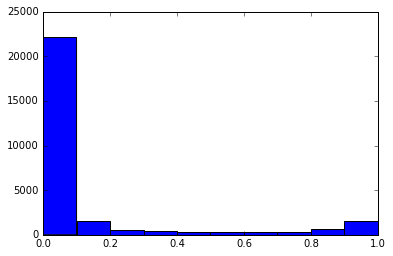

In [286]:
plt.hist(disc_model.marginals(F_dev))

### Quickly checking against SKL (w/ hard-thresholded marginals)

In [222]:
from sklearn.linear_model import LogisticRegression

covered = np.where(np.abs(train_marginals - 0.5) > 1e-3)[0]
tms     = train_marginals[covered]
X_cov   = F_train[covered]
tms     = np.array([1.0 if x > 0.5 else 0.0 for x in tms])

model = LogisticRegression(C=1e2, fit_intercept=True)

%time model.fit(X_cov, tms)

CPU times: user 1.53 s, sys: 9.78 ms, total: 1.54 s
Wall time: 1.54 s


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [223]:
yp_sk = model.predict(F_train)
get_score(yp_sk, L_gold_train)

P :	0.793393219357
R :	0.710062240664
F1:	0.74941836595


In [224]:
yp_sk = model.predict(F_dev)
get_score(yp_sk, L_gold_dev)

P :	0.791768292683
R :	0.65713562753
F1:	0.718196902655


(array([ 17344.,    401.,    470.,    125.,     89.,   6848.,    133.,
           225.,    297.,   2155.]),
 array([  6.51032556e-46,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

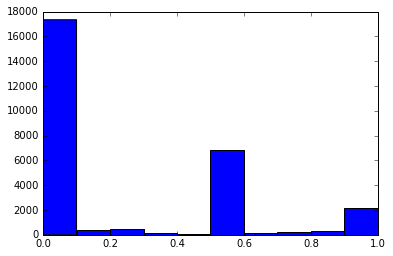

In [217]:
plt.hist(train_marginals)

(array([  3.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   5.00000000e+00,   1.10000000e+01,
          1.42000000e+02,   1.08000000e+03,   1.85000000e+02,
          1.84000000e+02]),
 array([ 0.08313505,  0.17481694,  0.26649883,  0.35818072,  0.4498626 ,
         0.54154449,  0.63322638,  0.72490827,  0.81659015,  0.90827204,
         0.99995393]),
 <a list of 10 Patch objects>)

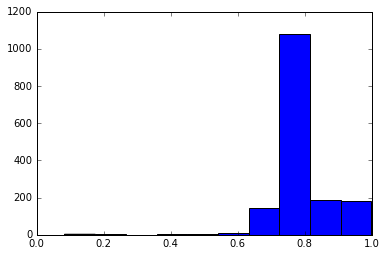

In [213]:
from snorkel.learning.gen_learning import odds_to_prob

plt.hist(odds_to_prob(gen_model.w))

In [214]:
L_train.lf_stats(labels=L_gold_train, est_accs=odds_to_prob(gen_model.w))

,j,coverage,overlaps,conflicts,accuracy,Learned Acc.
C_14,0,0.019689,0.018799,0.010788,0.889693,0.978413
F_03,1,0.004308,0.004130,0.001994,0.834711,0.811415
C_04,2,0.005839,0.005056,0.003596,0.475610,0.769572
C_26,3,0.003311,0.002243,0.001816,0.236559,0.694662
C_02,4,0.000570,0.000570,0.000498,0.625000,0.718046
E_01_370,5,0.009684,0.009649,0.001816,0.992647,0.999312
N_02_278,6,0.000926,0.000819,0.000320,1.000000,0.796726
N_06_230,7,0.000356,0.000320,0.000000,1.000000,0.757897
G_07_203,8,0.002065,0.001709,0.000214,1.000000,0.839869
G_10_261,9,0.000534,0.000534,0.000036,1.000000,0.819280


# ERROR ANALYSIS

In [133]:
CID_to_MESH = {}
for mid, cid in MESH_to_CID.iteritems():
    CID_to_MESH[cid] = mid

In [240]:
from random import shuffle
N_dev = L_gold_dev.shape[0]

fps = []
fns = []
for i in range(N_dev):
    if yp[i] > 0 and L_gold_dev[i] < 0:
        fps.append(i)
    elif yp[i] < 0 and L_gold_dev[i] > 0:
        fns.append(i)

shuffle(fps)
shuffle(fns)

print len(fps)
print len(fns)

566
1388


In [241]:
fn_cands = [F_dev.get_candidate(i) for i in fns[:100]]
svn      = SentenceNgramViewer(fn_cands, session)
svn

<IPython.core.display.Javascript object>

In [242]:
exact_match = 0
for i in fns:
    c = F_dev.get_candidate(i)
    if c.disease.get_span() in mesh_tree:
        exact_match += 1

In [243]:
exact_match

158

In [230]:
c = svn.get_selected()

mesh_tree[c.disease.get_span()]

[('D000437', ['C', '25', '775', '100', '250']),
 ('D000437', ['F', '03', '900', '100', '350'])]

In [231]:
c.disease.get_attrib_tokens('pos_tags')

[u'NN', u'NN']

In [232]:
mesh_tree['alcohol abuse']

[('D000437', ['C', '25', '775', '100', '250']),
 ('D000437', ['F', '03', '900', '100', '350'])]

In [233]:
from snorkel.models import Label

l = session.query(Label).filter(Label.candidate == c).one()
CID_to_MESH[l.value]

'D000437'

In [234]:
i = F_dev.get_row_index(c)
[(F_dev.get_key(k), disc_model.w[k]) for k in F_dev.getrow(i).nonzero()[1]]

[(AnnotationKey (DDL_WORD_POS_[NN]), -1.7737294483334323),
 (AnnotationKey (DDL_POS_SEQ_[NN NN]), -0.72989789733127697),
 (AnnotationKey (DDL_WORD_CLASS_[aaaaaaa]), 0.15917115605132481),
 (AnnotationKey (DDL_CHARACTER_N_GRAM_[co]), -0.065880115125777711),
 (AnnotationKey (DDL_CHARACTER_N_GRAM_[al]), 0.11240885199177029),
 (AnnotationKey (DDL_CHARACTER_N_GRAM_[l ]), 0.45953301311312988),
 (AnnotationKey (DDL_WORD_CLASS_[aaaaa]), -0.02304564826274982),
 (AnnotationKey (DDL_CHARACTER_N_GRAM_[us]), 0.4446693825948464),
 (AnnotationKey (DDL_CHARACTER_N_GRAM_[se]), -0.084142970216229837),
 (AnnotationKey (DDL_CHARACTER_N_GRAM_[use]), 0.11681093303882047),
 (AnnotationKey (DDL_DEP_SEQ_[compound nmod]), 0.06934625747050284),
 (AnnotationKey (DDL_WORD_PREFIX_al), 0.065204207089083824),
 (AnnotationKey (DDL_CHARACTER_N_GRAM_[ a]), 0.18225081140850766),
 (AnnotationKey (DDL_CHARACTER_N_GRAM_[l a]), -0.19585746767652984),
 (AnnotationKey (DDL_WORD_SUFFIX_se), -0.7398571784809167),
 (AnnotationKey 

In [140]:
F_dev.get_key(1)

AnnotationKey (DDL_WORD_POS_[NN])

* Why is Parkinson's disease not caught?

In [88]:
from snorkel.viewer import SentenceNgramViewer
fp_cands = [F_dev.get_candidate(i) for i in fps[:100]]
sv       = SentenceNgramViewer(fp_cands, session)
sv

<IPython.core.display.Javascript object>

In [ ]:
NEG_PHRASES = [
    'stenosis',
    'further attention',
    'presence',
    'absence',
    'syndrome',
    'association',
    'strain',
    'progression'
]

NEG_END_WORDS = [
    'therapies',
    'muscles',
    'concentrations',
    'normal',
    'heart',
    'side',
    'sinus',
    'convulsants',
    'latencies',
    'findings',
    'doses',
    'remission'
]

def end_in_plural(c):
    pass

def body_part(c):
    pass

def not_exact_single_word(d):
    pass

# TODO:

0. _DONE: Add negative labels to candidates..._
1. _DONE: Get empirical LF accs up and running..._
2. _DONE: Binarize LFs + run in binary gen model_
0. _DONE: Add TF-IDF matching LFs_
3. _DONE: Add in simple DDLIB + WS feats from new-features -> run disc. model_
2. **Conduct TYPE II "experiment"!**

## Creating Labeling Functions
Labeling functions are a core tool of data programming. They are heuristic functions that aim to classify candidates correctly. Their outputs will be automatically combined and denoised to estimate the probabilities of training labels for the training data.

In [ ]:
import re
from lf_terms import *
from snorkel.lf_helpers import get_left_tokens, get_right_tokens
from utils import *

umls_dict              = load_umls_dictionary()
chemicals              = load_chemdner_dictionary()
abbrv2text, text2abbrv = load_specialist_abbreviations()

We also load some publicly-available biomedical dictionaries, which we will leverage in some of our LFs below as a source of weak supervision:

In [ ]:
from utils import *

umls_dict              = load_umls_dictionary()
chemicals              = load_chemdner_dictionary()
abbrv2text, text2abbrv = load_specialist_abbreviations()

#### Document-Level Labeling Functions
We start with some labeling functions that label candidates based on document-level features.

In [ ]:
from snorkel.lf_helpers import get_doc_candidate_spans

def LF_undefined_abbreviation(c):
    '''Candidate is a known abbreviation, but no corresponding full name in document'''
    doc_spans = get_doc_candidate_spans(c)
    phrase = c[0].get_span().lower()
    mentions = set([s.get_span().lower() for s in doc_spans])
    if len(phrase) > 1 and phrase in abbrv2text and not set(abbrv2text[phrase].keys()).intersection(mentions):
        return -1
    return 0

#### Sentence-Level Labeling Functions
We also include some labeling functions that label candidates based on sentence-level features.

In [ ]:
from snorkel.lf_helpers import get_sent_candidate_spans

def LF_contiguous_mentions(c):
    '''Contiguous candidates are likely wrong'''
    neighbor_spans = get_sent_candidate_spans(c)
    start, end = c[0].get_word_start(), c[0].get_word_end()
    for s in neighbor_spans:
        if s.get_word_end() + 1 == start or s.get_word_start() - 1 == end:
            return -1
    return 0

#### Mention-Level Labeling Functions
We now define a number of labeling functions that label candidates based on attributes related to the mention.

In [ ]:
from snorkel.lf_helpers import get_left_tokens, get_right_tokens

def LF_tumors_growths(c):
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("^(\w* ){0,2}(['] )*(tumor|tumour|polyp|pilomatricoma|cyst|lipoma)$", phrase) else 0

def LF_cancer(c):
    '''<TYPE> cancer'''
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("\w* cancer",phrase) else 0

def LF_disease_syndrome(c):
    '''<TYPE> disease or <TYPE> syndrome'''
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("\w* (disease|syndrome)+",phrase) else 0

def LF_indicators(c):
    '''Indicator words'''
    return 1 if " ".join(c[0].get_attrib_tokens()).lower() in indicators else 0

def LF_common_disease(c):
    '''Common disease'''
    return 1 if " ".join(c[0].get_attrib_tokens()).lower() in common_disease else 0

*For a few more examples of LFs of this style that we'll use, see [Disease_Tagging_Tutorial_LFs.py](Disease_Tagging_Tutorial_LFs.py).*

#### Dictionary Labeling Functions
We can use existing dictionaries for distant supervision.

In [ ]:
def LF_SNOWMED_CT_sign_or_symptom(c):
    return 1 if c[0].get_span() in umls_dict["snomedct"]["sign_or_symptom"] else 0

def LF_SNOWMED_CT_disease_or_syndrome(c):
    return 1 if c[0].get_span() in umls_dict["snomedct"]["disease_or_syndrome"] else 0

def LF_MESH_disease_or_syndrome(c):
    return 1 if c[0].get_span() in umls_dict["mesh"]["disease_or_syndrome"] else 0

def LF_MESH_sign_or_symptom(c):
    return 1 if c[0].get_span() in umls_dict["mesh"]["sign_or_symptom"] else 0

#### Negative Labeling Functions
When writing labeling functions, it is important to provide negative supervision in addition to positive supervision.

In [ ]:
def LF_organs(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in organs else 0      

def LF_chemical_name(c):
    phrase = " ".join(c[0].get_attrib_tokens())
    return -1 if phrase in chemicals and not phrase.isupper() else 0

def LF_bodysym(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in bodysym else 0  

def LF_protein_chemical_abbrv(c):
    '''Gene/protein/chemical name'''
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("\d+",lemma) else 0

def LF_base_pair_seq(c): 
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("^[GACT]{2,}$",lemma) else 0

*For a few more examples of LFs of this style that we'll use, see [Disease_Tagging_Tutorial_LFs.py](Disease_Tagging_Tutorial_LFs.py).*

We maintain a list of all LFs for convenience.

In [ ]:
from Disease_Tagging_Tutorial_LFs import *

LFs_doc = [LF_undefined_abbreviation]

LFs_sent = [LF_contiguous_mentions]

LFs_mention = [LF_tumors_growths,
               LF_cancer,
               LF_disease_syndrome,
               LF_indicators,
               LF_common_disease,
               LF_common_disease_acronyms,
               LF_deficiency_of,
               LF_positive_indicator,
               LF_left_positive_argument,
               LF_right_negative_argument,
               LF_medical_afixes,
               LF_adj_diseases
              ]

LFs_dicts =  [LF_SNOWMED_CT_sign_or_symptom,
              LF_SNOWMED_CT_disease_or_syndrome,
              LF_MESH_disease_or_syndrome,
              LF_MESH_sign_or_symptom
            ]

LFs_false = [LF_chemical_name,
             LF_organs,
             LF_bodysym,
             LF_protein_chemical_abbrv,
             LF_base_pair_seq,
             LF_too_vague,
             LF_neg_surfix,
             LF_non_common_disease,
             LF_non_disease_acronyms,
             LF_pos_in,
             LF_gene_chromosome_link,
             LF_right_window_incomplete,
             LF_negative_indicator
            ]

## Applying Labeling Functions

First we construct a `CandidateLabeler`.

In [ ]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

Next we run the `CandidateLabeler` to to apply the labeling functions to the training `CandidateSet`.  We'll start with some of our labeling functions:

In [ ]:
LFs = LFs_mention + LFs_dicts + LFs_false
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

**OR** load if we've already created:

In [ ]:
%time L_train = label_manager.load(session, train, 'LF Labels')
L_train

We can also add or rerun a single labeling function (or more!) with the below command. Note that we set the argument `expand_key_set` to `True` to indicate that the set of matrix columns should be allowed to expand:

In [ ]:
LFs_2   = LFs_doc + LFs_sent
L_train = label_manager.update(session, train, 'LF Labels', True, f=LFs_2)
L_train

We can view statistics about the resulting label matrix:

In [ ]:
L_train.lf_stats()

## Fitting the Generative Model
We estimate the accuracies of the labeling functions without supervision. Specifically, we estimate the parameters of a `NaiveBayes` generative model.

In [ ]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train)

In [ ]:
gen_model.save(session, 'Generative Params')

We now apply the generative model to the training candidates.

In [ ]:
train_marginals = gen_model.marginals(L_train)

## Training the Discriminative Model
We use the estimated probabilites to train a discriminative model that classifies each `Candidate` as a true or false mention.

In [ ]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=5000, rate=1e-3)

In [ ]:
disc_model.w.shape

In [ ]:
%time disc_model.save(session, "Discriminative Params")

## Evaluating on the Development `CandidateSet`

First, we create features for the development set.

Note that we use the training features feature set, because those are the only features for which we have learned parameters. Features that were not encountered during training, e.g., a token that does not appear in the training set, are ignored, because we do not have any information about them.

To do so with the `FeatureManager`, we call update with the new `CandidateSet`, the name of the training `AnnotationKeySet`, and the value `False` for the parameter `extend_key_set` to indicate that the `AnnotationKeySet` should not be expanded with new `Feature` keys encountered during processing.

In [ ]:
%time F_dev = feature_manager.update(session, dev, 'Train Features', False)

**OR** if we've already created one, we can simply load as follows:

In [ ]:
%time F_dev = feature_manager.load(session, dev, 'Train Features')

Next, we load the development set labels and gold candidates we made in Part III.

In [ ]:
L_gold_dev = label_manager.load(session, dev, "CDR Development Labels -- Gold")

In [ ]:
gold_dev_set = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates -- Gold').one()

Now we can evaluate the discriminative model on the development set.

In [ ]:
tp, fp, tn, fn = disc_model.score(F_dev, L_gold_dev, gold_dev_set)

## Viewing Examples
After evaluating on the development `CandidateSet`, the labeling functions can be modified. Try changing the labeling functions to improve performance. You can view the true positives, false positives, true negatives, and false negatives using the `Viewer`.

In [ ]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(tp, session, annotator_name="Tutorial Part IV User")
else:
    sv = None

In [ ]:
sv

Next, in Part V, we will test our model on the test `CandidateSet`.